In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import torch, IPython, itertools, string
import random, time, warnings
import matplotlib.pyplot as plt
from matplotlib import animation
from munch import Munch

In [3]:
warnings.simplefilter('ignore')

In [4]:
class Point(torch.nn.Module):
    def __init__(self, linkage, name):
        super(Point, self).__init__()
        self.linkage = linkage
        self.name = name
        
    def __repr__(self):
        raise Exception('Override this method.')
    
    @property
    def r(self):
        raise Exception('Override this property.')

    def root(self):
        raise Exception('Override this method.')
    
    def E(self):
        raise Exception('Override this method.')
        
    def add_frompointline(self, L, theta, phi=None, ux=None, uz=None):
        new_line = self.linkage.add_frompointline(self, L, theta, phi, ux, uz)
        return(new_line)

In [5]:
class AtPoint(Point):
    def __init__(self, linkage, name, at):
        super(AtPoint, self).__init__(linkage, name)
        self._r = torch.nn.Parameter(torch.tensor(at).to(torch.float))
    
    def __repr__(self):
        label = self.__class__.__name__[:-5]
        return('[{}]Point_{}(at={})'.format(label, self.name, str(self.r.tolist())))
    
    @property
    def r(self):
        return(self._r)

    def root(self):
        return(self)
    
    def E(self):
        return(0)

In [6]:
class AnchorPoint(Point):
    def __init__(self, linkage, name, at):
        super(AnchorPoint, self).__init__(linkage, name)
        self._r = torch.tensor(at, requires_grad=False)
        
    def __repr__(self):
        label = self.__class__.__name__[:-5]
        return('[{}]Point_{}(at={})'.format(label, self.name, str(self.r.tolist())))
        
    @property
    def r(self):
        return(self._r)
        
    def root(self):
        return(self)
    
    def E(self):
        return(0)

In [7]:
class OnPointPoint(Point):
    def __init__(self, linkage, name, parent):
        super(OnPointPoint, self).__init__(linkage, name)
        self.parent = parent
        
    def __repr__(self):
        label = self.__class__.__name__[:-5]
        return('[{}]Point_{}(on={})'.format(label, self.name, str(self.parent)))
        
    @property
    def r(self):
        return(self.parent.r)
    
    def root(self):
        return(self.parent.root())
    
    def E(self):
        return(0)

In [8]:
class ToPointPoint(Point):
    def __init__(self, linkage, name, at, parent):
        super(ToPointPoint, self).__init__(linkage, name)
        self._r = torch.nn.Parameter(torch.tensor(at).to(torch.float))
        self.parent = parent
        
    def __repr__(self):
        label = self.__class__.__name__[:-5]
        return('[{}]Point_{}(to={})'.format(label, self.name, str(self.parent)))
        
    @property
    def r(self):
        return(self._r)
    
    def root(self):
        return(self)
    
    def E(self):
        return((self.r-self.parent.r).pow(2).sum())

In [9]:
class CalculatedPoint(Point):
    def __init__(self, linkage, name, parent):
        super(CalculatedPoint, self).__init__(linkage, name)
        self.parent = parent
        
    def __repr__(self):
        label = self.__class__.__name__[:-5]
        return('[{}]Point_{}(from={})'.format(label, self.name, str(self.parent.p1)))
        
    @property
    def r(self):
        if self.parent.ux is None:
            ax = torch.tensor([1,0,0], requires_grad=False).to(torch.float)
        elif type(self.parent.ux) is list:
            ax = torch.tensor(ux, requires_grad=False).to(torch.float)
        elif type(self.parent.ux).__bases__[0].__name__ is 'Line':
            ax = self.parent.ux.u
        else:
            raise Exception('ux must be None, a list, or a Line.')
        if self.parent.uz is None:
            az = torch.tensor([0,0,1], requires_grad=False).to(torch.float)
        elif type(self.parent.uz) is list:
            az = torch.tensor(uz, requires_grad=False).to(torch.float)
        elif type(self.parent.uz).__bases__[0].__name__ is 'Line':
            az = self.parent.uz.u
        else:
            raise Exception('uz must be None, a list, or a Line.')
        ay = torch.cross(az, ax)
        theta = self.parent.theta * np.pi/180
        phi = self.parent.phi * np.pi/180
        ux = torch.sin(phi)*torch.cos(theta)
        uy = torch.sin(phi)*torch.sin(theta)
        uz = torch.cos(phi)
        dr = self.parent.L * torch.cat([ux, uy, uz])
        R = torch.stack([ax, ay, az], dim=1)
        r = self.parent.p1.r + torch.matmul(R,dr)
        return(r)

    def root(self):
        return(self)
    
    def E(self):
        return(0)

In [10]:
class Line(torch.nn.Module):
    def __init__(self, linkage, name):
        super(Line, self).__init__()
        self.linkage = linkage
        self.name = name
        self.parent = None
        self.p1 = None
        self.p2 = None
        
    def __repr__(self):
        raise Exception('Override this method.')
        
    @property
    def r(self):
        return(self.p2.r-self.p1.r)
    
    def root(self):
        raise Exception('Override this method.')
    
    def E(self):
        raise Exception('Override this method.')
    
    def is_constrained(self):
        raise Exception('Override this method.')
        
    def add_onlinepoint(self):
        new_point = self.linkage.add_onlinepoint(self)
        return(new_point)

In [11]:
class FromPointLine(Line):
    def __init__(self, linkage, name, p, L, theta, phi=None, ux=None, uz=None):
        super(FromPointLine, self).__init__(linkage, name)
        self.L = L
        self.theta = torch.nn.Parameter(torch.tensor([theta]).to(torch.float))
        phi = 90 if phi is None else phi
        self.phi = torch.nn.Parameter(torch.tensor([phi]).to(torch.float))
        self.ux = ux
        self.uz = uz
        self.p1 = OnPointPoint(self.linkage, '{}.{}'.format(self.name, '1'), parent=p)
        self.p2 = CalculatedPoint(self.linkage, '{}.{}'.format(self.name, '2'), parent=self)
        
    def __repr__(self):
        label = self.__class__.__name__[:-4]
        return('[{}]Line_{}(p1={}, p2={})'.format(label, self.name, self.p1.name, self.p2.name))
    
    @property
    def u(self):
        return(self.r/self.L)

    def root(self):
        return(self)
    
    def E(self):
        return(0)
    
    def is_constrained(self):
        return(True)

In [12]:
class OnLinePoint(Point):
    def __init__(self, linkage, name, parent):
        super(OnLinePoint, self).__init__(linkage, name)
        self.parent = parent
        self.alpha = torch.nn.Parameter(torch.tensor([0.5]))
        
    def __repr__(self):
        label = self.__class__.__name__[:-5]
        return('[{}]Point_{}(on={})'.format(label, self.name, str(self.parent)))
    
    @property
    def r(self):
        return(self.alpha*self.parent.p1.r+(1-self.alpha)*self.parent.p2.r)

    def root(self):
        return(self)
    
    def E(self):
        return(0)

In [13]:
class OnPointLine(Line):
    pass

In [14]:
class Linkage():
    def __init__(self):       
        self.points = Munch(torch.nn.ModuleDict({}))
        self.lines = Munch(torch.nn.ModuleDict({}))
        #self.angles = torch.nn.ModuleDict({})
        self.names = {}
        for _type in ['point', 'line']:
            self.names[_type] = []
            letters = string.ascii_letters[-26:]
            if _type is 'line':
                letters = letters.lower()
            for n in range(3):
                for t in itertools.product(letters, repeat=n):
                    self.names[_type].append(''.join(t))
            self.names[_type] = iter(self.names[_type][1:])
        self.plot = LinkagePlot(self)
        self.tolerance = 0.00001
    
    # Points
    
    def add_atpoint(self, at):
        name = next(self.names['point'])
        self.points[name] = AtPoint(self, name, at)
        self.plot.update()
        return(self.points[name])
    
    def add_anchorpoint(self, at):
        name = next(self.names['point'])
        self.points[name] = AnchorPoint(self, name, at)
        self.plot.update()
        return(self.points[name])
    
    def add_onpointpoint(self, parent):
        name = next(self.names['point'])
        self.points[name] = OnPointPoint(self, name, parent)
        self.plot.update()
        return(self.points[name])
    
    def add_topointpoint(self, at, parent):
        name = next(self.names['point'])
        self.points[name] = ToPointPoint(self, name, at, parent)
        self.plot.update()
        return(self.points[name])
    
    def add_onlinepoint(self, parent):
        name = next(self.names['point'])
        self.points[name] = OnLinePoint(self, name, parent)
        self.plot.update()
        return(self.points[name])
    
    # Lines
    
    def add_frompointline(self, p, L, theta, phi=None, ux=None, uz=None):
        name = next(self.names['line'])
        self.lines[name] = FromPointLine(self, name, p, L, theta, phi, ux, uz)
        self.plot.update()
        return(self.lines[name])
    
    def add_onpointline(self):
        pass
        
    @property
    def N(self):
        N = 0
        N += len(self.points)
        N += 2*len(self.lines)
        return(N)
    
    @property
    def M(self):
        return(len(self.lines))
     
    def parameters(self):
        parameters = []
        for point in self.points.values():
            for param in point.parameters():
                parameters.append(param)
        for line in self.lines.values():
            for param in line.parameters():
                parameters.append(param)
        return(parameters)
       
    def energy(self):
        E = 0.0
        for point in self.points.values():
            E += line.energy()
        for line in self.lines.values():
            E += line.energy()
        #for angle in self.angles.values():
        #    E += angle.energy()
        return(E)
            
    def update(self, max_num_epochs=10000):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001) #SGD
        for epoch in range(max_num_epochs):
            optimizer.zero_grad()
            E = self.energy()
            E.backward()
            optimizer.step()
            self.plot.E_list.append(E.item())
            if E <= self.tolerance:
                break
        if (E > self.tolerance or E.isnan()):
            raise Exception('Could not solve all constraints.')
        self.plot.update()
        time.sleep(0.01)

In [15]:
class LinkagePlot():
    def __init__(self, linkage):
        self.linkage = linkage
        self.origin = torch.tensor([0,0,0])
        self.E_list = [1.0]
        
        # Set up figure and axis
        self.size = 5
        self.lim = 5
        self.fig = plt.figure(figsize=(2*self.size,self.size))
        self.ax1 = self.fig.add_subplot(121, autoscale_on=False,
            xlim=(-self.lim,self.lim),
            ylim=(-self.lim,self.lim))
        self.ax2 = self.fig.add_subplot(122, autoscale_on=False,
            xlim=(0,1),
            ylim=(0,1))
        self.ax1.set_title('Configuration')
        self.ax2.set_title('log10(E)')
        
        self.ax1.scatter(
            [self.origin[0]], [self.origin[1]],
            marker='o', s=20, c='red', alpha=1, label='origin')
        
        self.points, self.anchors, self.lines = {}, {}, {}
            
        self.lnE_line, = self.ax2.plot([], [], 'b-', markersize=3, lw=0.5, label='log10(E)')
        time_template = ' t={:.0f}\n E={:.2f}\n T={:.5f}\n theta={:.0f}\n'
        self.time_text = self.ax1.text(0.05, 0.7, '', transform=self.ax1.transAxes)
        
    def update(self):
        
        for point_name in self.linkage.points.keys():
            #print('point', point_name)
            if self.linkage.points[point_name].__class__.__name__ is 'AnchorPoint':
                color = 'blue'
                size = 150
            else:
                color = 'limegreen'
                size = 50
            if point_name not in self.points.keys():
                point = self.ax1.scatter([], [], s=size, c=color,
                    zorder=0, label=point_name)
                self.points[point_name] = point
            point = self.linkage.points[point_name]
            self.points[point_name].set_offsets(
                [[point.r[0],point.r[1]]])
                
        for line_name in self.linkage.lines.keys():
            #print('line', line_name)
            ls, lw = ':', 1
            if self.linkage.lines[line_name].is_constrained():
                ls, lw = '-', 1
            if line_name not in self.lines.keys():
                line, = self.ax1.plot([], [], linestyle=ls, markersize=3, lw=lw, c='black',
                    zorder=0, label=line_name)
                self.lines[line_name] = line
            line = self.linkage.lines[line_name]
            self.lines[line_name].set_data(
                [line.p1.r[0],line.p2.r[0]],
                [line.p1.r[1],line.p2.r[1]])
            self.lines[line_name].set_linestyle(ls)
            self.lines[line_name].set_linewidth(lw)
            for p in [line.p1, line.p2]:
                #print('line_point', line_name, p.name)
                if p.name not in self.points.keys():
                    point = self.ax1.scatter([], [], s=10, c='red',
                        zorder=0, label=p.name)
                    self.points[p.name] = point
                self.points[p.name].set_offsets(
                    [[p.r[0],p.r[1]]])
            
        self.lnE_line.set_xdata(torch.arange(0,len(self.E_list)))
        self.lnE_line.set_ydata(torch.log10(torch.tensor(self.E_list)))
        self.ax2.set_xlabel('Epoch')
        self.ax2.set_xlim(0,len(self.E_list))
        self.ax2.set_ylim(-10,10)
        self.time_text.set_text('')
        self.fig.canvas.draw()

<IPython.core.display.Javascript object>


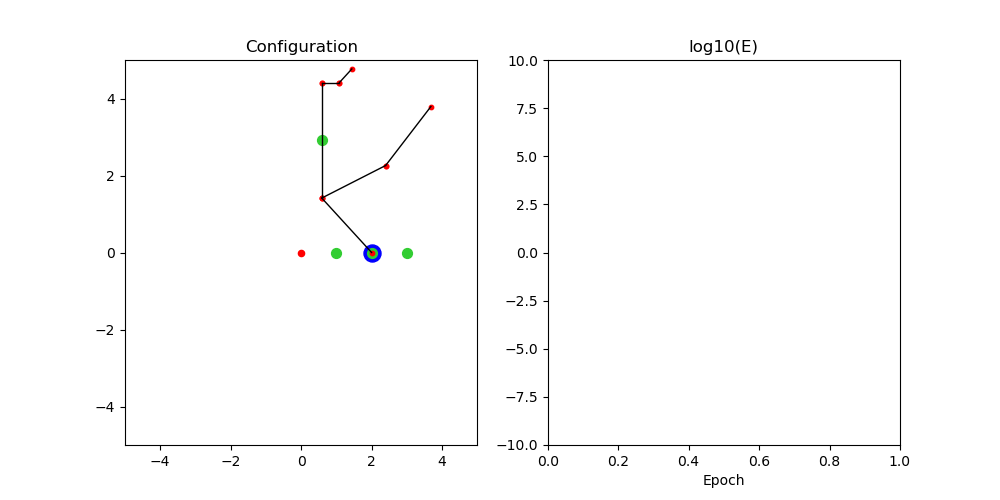

In [16]:
linkage = Linkage()

In [17]:
A = linkage.add_atpoint(at=[1,0,0])

In [18]:
B = linkage.add_anchorpoint(at=[2,0,0])

In [19]:
C = linkage.add_onpointpoint(parent=B)

In [20]:
D = linkage.add_topointpoint(parent=C, at=[3,0,0])

In [21]:
a = linkage.add_frompointline(p=C, L=2, theta=135, phi=None, ux=None, uz=None)

In [22]:
b = a.p2.add_frompointline(L=2, theta=25, phi=None, ux=None, uz=None)

In [23]:
c = b.p2.add_frompointline(L=2, theta=25, phi=None, ux=b, uz=None)

In [24]:
d = b.p1.add_frompointline(L=3, theta=90, phi=None, ux=None, uz=None)

In [25]:
e = d.p2.add_frompointline(L=0.5, theta=-90, phi=None, ux=d, uz=None)

In [26]:
f = e.p2.add_frompointline(L=0.5, theta=45, phi=None, ux=None, uz=None)

In [27]:
E = d.add_onlinepoint()